# Object Detection inference

In [164]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import cv2
import re
import math
import os, ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt # plotting
import matplotlib.patches as patches

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from pathlib import Path


## pytorch imports ##
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

from datasets import load_dataset, Dataset, DatasetDict, Image,IterableDataset
from datasets.iterable_dataset import iterable_dataset
from datasets import Features, Sequence, Value, ClassLabel

# cv2
import cv2
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


from models.rcnn import LitWheat
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from functools import partial

dataset_path = Path('/extras/Data')
dataset_img_train = dataset_path/'train'
dataset_img_test = dataset_path/'test'
WANDB_PROJECT = "wheat-detection"

import wandb
wandb.login()

# Using a small image size so it trains faster but do try bigger images 
# for better performance.
IMG_SIZE = 256

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=IMG_SIZE, width=IMG_SIZE, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=256, width=256, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )



def get_test_transforms():
    return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ], p=1.0)

def annotate_examples(examples, idx):
    image_id = examples['image_id']
    examples['boxes'] = np.array(examples['boxes'])
    examples['images']= str(dataset_img_train/(image_id+".jpg"))
    examples['labels'] = np.ones(examples['boxes'].shape[0])
    examples['area'] = examples['box_area']
    examples['iscrowd'] = np.zeros(examples['boxes'].shape[0])
    examples['image_id'] = idx

        
    return examples

def test_transform(example, transform=None):
    image = np.array(example['images'][0])
    if transform is not None:
        transformed = transform(image=image)
        image = transformed['image']
    
    example['pixel_values'] = [image]

    return example

def image_transform(example, transform=None):
    image = np.array(example['images'][0])
    boxes = np.array(example['boxes'][0])
    if transform is not None:
        transformed = transform(image=image, bboxes = boxes,labels=['wheat_head']*len(boxes))
        image = transformed['image']
        boxes = transformed['bboxes']
        
    if len(boxes) > 0:
        boxes = torch.stack([torch.tensor(item) for item in boxes])
    else:
        boxes = torch.zeros((0, 4))
    
    example['pixel_values'] = [image]
    example['boxes'] = [boxes]
    return example
        
    
    
    return example

def prepare_data():
    train_df = pd.read_csv(dataset_path/'train.csv')
    test_df = pd.read_csv(dataset_path/'test.csv')
    sample_sub_df = pd.read_csv(dataset_path/'sample_submission.csv')    
    
    train_df['x_min']=train_df['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[0])[0]))
    train_df['y_min']=train_df['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[1])[0]))
    train_df['box_width']=train_df['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[2])[0]))
    train_df['box_height']=train_df['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[3])[0]))
    
    train_df.drop('bbox',axis=1,inplace=True)

    train_df['box_area']=train_df['box_width']*train_df['box_height']
    train_df['x_max']=train_df['x_min']+train_df['box_width']
    train_df['y_max']=train_df['y_min']+train_df['box_height']
    
    train_df['count'] = train_df.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
    train_df['boxes'] = list(train_df[['x_min','y_min','x_max','y_max']].values.tolist())
    combined_train = train_df.groupby(['image_id']).agg({'count': 'sum', 'boxes': list,'box_area': list})
    
    
    ds = Dataset.from_pandas(combined_train)
    processed_ds = (ds.map(annotate_examples,batched=False, with_indices=True)
                .cast_column('images', Image(decode=True))
               
               )
    
    dds = processed_ds.train_test_split(test_size=0.2)
    
    
    dds['train'].set_transform(partial(image_transform, transform = get_train_transforms()))
    dds['test'].set_transform(partial(image_transform, transform = get_valid_transforms()))
    
    return dds
    

def collate_fn(batch,test=False):
    
    images = []
    labels = []
    image_ids = []

    for example in batch:
        # apply train transforms
        image = example['pixel_values']
        image_id = example['image_id']
        images.append(image)
        image_ids.append(image_id)
        if not test:
            label = {
                'boxes' : example['boxes'].float(),
                'labels': torch.tensor(example['labels'],dtype=torch.int64),
                'area': torch.tensor(example['area']),
                'iscrowd': torch.tensor(example['iscrowd']),
                'image_id': torch.tensor(example['image_id'])
            }
            labels.append(label)
        
    pixel_values = torch.stack(images)
    if not test:
        return {'pixel_values': pixel_values, 'labels': labels, 'image_ids': image_ids}
    else:
        return {'pixel_values': pixel_values, 'image_ids': image_ids}
    
def get_dataloaders(dds):
    return (DataLoader(
        dds['train'],
        batch_size=8, shuffle=True, collate_fn=collate_fn,
        num_workers=4),
        DataLoader(dds['test'],batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=4))


def main():
    dds = prepare_data()
    
    early_stop_callback = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00,
        patience=3,
        verbose=False,
        mode='max'
    )
    
    logger = WandbLogger(project=WANDB_PROJECT, log_model=True)
    trainer = pl.Trainer( gpus=2, progress_bar_refresh_rate=1, 
                         max_epochs=4,deterministic=False, precision=16,
                         logger = logger,callbacks=[early_stop_callback])

    detector = LitWheat(2)
    train_dl, test_dl = get_dataloaders(dds)
    trainer.fit(detector, train_dl, test_dl)
    
    # save the model
    torch.save(detector,"models/model.pth")

In [2]:
dds = prepare_data()

  0%|          | 0/3373 [00:00<?, ?ex/s]

/home/puneet/Envs/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


# Inference

In [159]:
import os
files = os.listdir(dataset_img_test)
file_paths = [str(dataset_img_test/f) for f in files]

In [165]:
test_ds = (Dataset.from_dict({'images':file_paths,'image_id': files})
           .cast_column('images',Image())
           .with_transform(partial(test_transform, transform=get_test_transforms()))
          )

In [101]:
test_dl = DataLoader(test_ds,batch_size=2, shuffle=True, collate_fn=partial(collate_fn,test=True), num_workers=1)


In [102]:
batch = next(iter(test_dl))

In [104]:
detector = LitWheat.load_from_checkpoint('None/hoj7wqd8/checkpoints/epoch=3-step=675.ckpt',n_classes=2)

In [105]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')

    return " ".join(pred_strings)

In [114]:
detection_threshold = 0.8
results = []

for batch in test_dl:
    images = batch['pixel_values']
    outputs = detector(images)
    image_ids = batch['image_ids']
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes[scores >= detection_threshold].astype(np.int32)
        scores[scores >= detection_threshold]
        
        image_id = image_ids[i]
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [115]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,51b3e36ab.jpg,0.9878 0 227 19 28 0.9866 209 112 46 37 0.9817...
1,f5a1f0358.jpg,0.9744 235 108 20 47 0.9739 170 51 30 23 0.969...
2,51f1be19e.jpg,0.9594 193 220 36 27 0.9563 196 5 23 18 0.9539...
3,aac893a91.jpg,0.9640 155 228 17 27 0.9456 113 214 20 23 0.86...
4,2fd875eaa.jpg,0.9889 0 227 26 21 0.9889 117 88 31 25 0.9881 ...


In [162]:
from torchvision import transforms
import PIL

In [143]:
sample = images[1].permute(1,2,0).cpu().numpy()
image_id = image_ids[1]
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

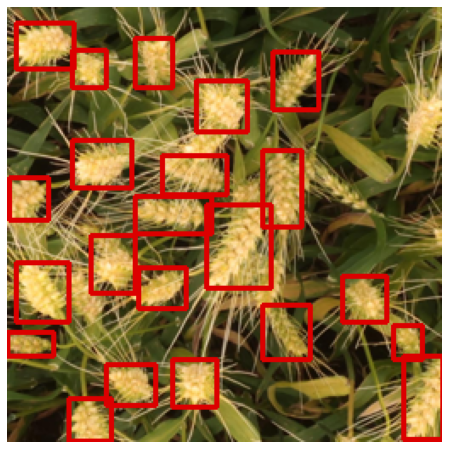

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
img_rgb = PIL.Image.open(dataset_img_test/(image_id)).resize((256,256))
#sample = cv2.cvtColor(np.float32(img_rgb), cv2.COLOR_RGB2RGB)
sample = np.array(img_rgb)
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)